#Image Filtering and Hybrid Images

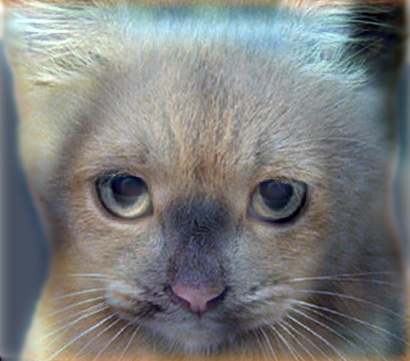

Look at the image from very close, then from far away.

##Introduction

We will learn how to create hybrid images in this project. A hybrid image is an image that is perceived differently depending on viewing distance, based on the way humans process visual input. The basic idea is that high frequency image content tends to dominate perception, but, at a distance, only the low frequency (smooth) part of the image can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, we can create a hybrid image that leads to different interpretations at different distances.


## Implementation Details

This project is intended to familiarize us with Python, NumPy, and image filtering. We will work on it step by step. Firstly, we need to import all the packages.

In [4]:
import numpy as np
from numpy import pi, exp, sqrt
from skimage import io, img_as_ubyte, img_as_float32
from skimage.transform import rescale
import os
import matplotlib.pyplot as plt

We will wirte an image convolution function (image filtering) and use it to create hybrid images (here are some [examples](http://olivalab.mit.edu/hybrid_gallery/gallery.html)). Image filtering (or convolution) is a fundamental image processing tool. See chapter 3.2 of Szeliski's book to learn about image filtering (specifically linear filtering). Numpy has numerous built in and efficient functions to perform image filtering, but we will be writing our own such function from scratch for this project. More specifically, we will implement cross_correlation_2d, followed by convolve_2d which would use cross_correlation_2d.

In [3]:
def cross_correlation_2d(img, kernel):
  """
  This function executes the cross correlation between 'img' and 'kernel'.
  """
  # Get size of the arrays. 3rd value of shape is colour channel for images.
  img_r, img_c, img_w = img.shape
  kernel_r, kernel_c = kernel.shape
  # padding image for the cross correlation
  (pad_r, pad_c) = (kernel_r//2, kernel_c//2)
  padded_arr1 = np.pad(img, ((pad_r, pad_r), (pad_c, pad_c)), mode='symmetric')
  # Create image to write to.
  output = np.zeros(img.shape)

  # Slide kernel across every pixel.
  for r in range(pad_r, img_r + pad_r):
    for c in range(pad_c, img_c + pad_c):
      for w in range(img_w):
        # Get center pixel.
        center = img[r-pad_r:r+pad_r+1, c-pad_c:c+pad_c+1, w]
        # Perform convolution and write back value to output image.
        output[r-pad_r, c-pad_c, w] = (center * kernel).sum()

  # Return the result of the crosss correlation.
  return output

In [2]:
def convolution_2d(img, kernel):
  """
  This function executes the convolution between 'img' and 'kernel'.
  """
  print("[{}]\tRunning convolution...\n".format(img))
  # Flip template before convolution.
  kernel = np.flip(kernel, (0, 1))

  return cross_correlation_2d(img, kernel)

To generate the Gaussian blur kernel:

In [ ]:
def gaussian_kernel_2d(kernel_size, sigma):
  """
  Generates a 2D Gaussian kernel.

  Args:
    kernel_size (int): The size of the square kernel (e.g., 3, 5, 7).
                       Should be an odd number.
    sigma (float): The standard deviation of the Gaussian distribution.

  Returns:
    numpy.ndarray: A 2D Gaussian kernel.
  """
  if kernel_size % 2 == 0:
    raise ValueError("Kernel size must be an odd number.")

  center = kernel_size // 2
  x, y = np.meshgrid(np.arange(-center, center + 1),
                      np.arange(-center, center + 1))

  kernel = (1 / (2 * np.pi * sigma**2)) * np.exp(-((x**2 + y**2) / (2 * sigma**2)))

  # Normalize the kernel so its sum is 1
  # return kernel / np.sum(kernel)
  return kernel

My function for image filtering:

In [1]:
def my_imfilter(img, filter):
  """
  Function to apply a filter to an image. Return the filtered image.
  Inputs:
  - img -> numpy nd-array of dim (m, n, c)
  - filter -> numpy nd-array of odd dim (k, l)
  Returns
  - filtered_image -> numpy nd-array of dim (m, n, c)
  Errors if:
  - filter has any even dimension -> raise an Exception with a suitable error message.
  """
  if filter.shape[0] % 2 == 0:
    raise ValueError("Kernel size must be an odd number.")

  return convolution_2d(img, filter)

To generate hybrid image:

In [ ]:
def gen_hybrid_image(image1, image2, cutoff_frequency):
  """
   Inputs:
   - image1 -> The image from which to take the low frequencies.
   - image2 -> The image from which to take the high frequencies.
   - cutoff_frequency -> The standard deviation, in pixels, of the Gaussian
                         blur that will remove high frequencies.

   Task:
   - Use my_imfilter to create 'low_frequencies' and 'high_frequencies'.
   - Combine them to create 'hybrid_image'.
  """

  assert image1.shape[0] == image2.shape[0]
  assert image1.shape[1] == image2.shape[1]
  assert image1.shape[2] == image2.shape[2]

  # Steps:
  # (1) Remove the high frequencies from image1 by blurring it. The amount of
  #     blur that works best will vary with different image pairs
  # generate a 1x(2k+1) gaussian kernel with mean=0 and sigma = s,
  # see https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
  s, k = cutoff_frequency, cutoff_frequency*2
  probs = np.asarray([exp(-z*z/(2*s*s))/sqrt(2*pi*s*s) for z in range(-k,k+1)], dtype=np.float32)
  kernel = np.outer(probs, probs)

  # low pass filtering
  low_frequencies = my_imfilter(image1, kernel)

  # (2) Remove the low frequencies from image2. The easiest way to do this is to
  #     subtract a blurred version of image2 from the original version of image2.
  #     This will give you an image centered at zero with negative values.
  # high pass filtering
  high_frequencies = image2 - my_imfilter(image2, kernel)

  # (3) Combine the high frequencies and low frequencies
  # to create hybrid image
  hybrid_image = np.clip(low_frequencies + high_frequencies, 0.0, 1.0)

  # (4) At this point, you need to be aware that values larger than 1.0
  # or less than 0.0 may cause issues in the functions in Python for saving
  # images to disk. These are called in proj1_part2 after the call to
  # gen_hybrid_image().
  # One option is to clip (also called clamp) all values below 0.0 to 0.0,
  # and all values larger than 1.0 to 1.0.

  return low_frequencies, high_frequencies, hybrid_image

To help visualize hybrid image:  

In [ ]:
def vis_hybrid_image(hybrid_image):
  """
  Visualize a hybrid image by progressively downsampling the image and
  concatenating all of the images together.
  """
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = 1 if hybrid_image.ndim == 2 else 3

  output = np.copy(hybrid_image)
  cur_image = np.copy(hybrid_image)
  for scale in range(2, scales+1):
    # add padding
    output = np.hstack((output, np.ones((original_height, padding, num_colors),
                                        dtype=np.float32)))
    # downsample image
    cur_image = rescale(cur_image, scale_factor, mode='reflect')
    # pad the top to append to the output
    pad = np.ones((original_height-cur_image.shape[0], cur_image.shape[1],
                   num_colors), dtype=np.float32)
    tmp = np.vstack((pad, cur_image))
    output = np.hstack((output, tmp))
  return output

To load image:

In [ ]:
def load_image(path):
  return img_as_float32(io.imread(path))

To save image:

In [ ]:
def save_image(path, im):
  return io.imsave(path, img_as_ubyte(im.copy()))

###Generate Hybrid Image

First, let's load the two images to be combined.

In [ ]:
# Read images and convert to floating point format
!wget https://github.com/yowangPVAMU/PythonCV/blob/main/Einstein.jpg
!wget https://github.com/yowangPVAMU/PythonCV/blob/main/Monroe.jpg
!wget https://github.com/yowangPVAMU/PythonCV/blob/main/dog.jpg
!wget https://github.com/yowangPVAMU/PythonCV/blob/main/cat.jpg
image1 = load_image('dog.jpg')
image2 = load_image('cat.jpg')
# You can load the other two images to create a different hybrid image

Here are the two images.

In [ ]:
plt.figure(figsize=(3,3)); plt.imshow((image1*255).astype(np.uint8));
plt.figure(figsize=(3,3)); plt.imshow((image2*255).astype(np.uint8));

Let's construct the hybrid image.

In [ ]:
cutoff_frequency = 7
low_frequencies, high_frequencies, hybrid_image = gen_hybrid_image(image1, image2, cutoff_frequency)

To visualize and save the outputs:

In [ ]:
plt.figure(); plt.imshow((low_frequencies*255).astype(np.uint8));
plt.figure(); plt.imshow(((high_frequencies+0.5)*255).astype(np.uint8));
vis = vis_hybrid_image(hybrid_image)
plt.figure(figsize=(20, 20)); plt.imshow(vis);

save_image('../results/low_frequencies.jpg', low_frequencies)
save_image('../results/high_frequencies.jpg', high_frequencies+0.5)
save_image('../results/hybrid_image.jpg', hybrid_image)
save_image('../results/hybrid_image_scales.jpg', vis)